In [1]:
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import glob
import splat
from popsims.relations import polynomial_relation
from splat.photometry import filterMag
import splat.empirical as spe
from tqdm import tqdm
import popsims
from popsims.plot_style import  plot_style
plot_style()
%matplotlib inline
#plt.style.use('dark_background') #for posters



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
def compute_colors(s, xkey, ykey):
    #print (xkey, ykey)
    xmag= filterMag(s ,xkey, ab=False)
    ymag= filterMag(s, ykey, ab=False)
    return xmag[0]-ymag[0], (xmag[1]**2+ymag[1]**2)**0.5

In [3]:
COLOR_TERMS=['LSST_GandLSST_R',
            'LSST_RandLSST_Z',
            'LSST_IandLSST_Z',
             'LSST_RandLSST_I',
             'LSST_ZandLSST_Y']

In [4]:
    

def spt_to_teff(spt, sd=True):
    if sd:
        if spt >25:  
            return  spe.typeToTeff(spt,  reverse=False, ref='pecaut')[0].value
        else:
            return spe.typeToTeff(spt, reverse=False, ref='gonzales18')[0].value
    if not sd:
        return spe.typeToTeff(teff,  reverse=False, ref='pecaut')[0].value
    
def teff_to_spt(teff, sd=True):
    if sd:
        if teff <1600: #use dwarfs for higher teff 
            return  spe.typeToTeff(teff,  reverse=True, ref='pecaut')[0]
        else:
            return spe.typeToTeff(teff, reverse=True, ref='gonzales18')[0]
    if not sd:
        return  spe.typeToTeff(teff,  reverse=True, ref='pecaut')[0]

In [5]:
#/subdwarfs_gerasimov.npy',

In [6]:
def get_sd_models(model='gerasimov'):
    #ADD models
    sdmodels=np.load('/Volumes/LaCie/popsimsdata/subdwarfs_models_{}.npy'.format(model), allow_pickle=True)[0]
    additional_keys=['SDSS_G', 'SDSS_R', 'SDSS_I', 'SDSS_Z', '2MASS J', '2MASS H', '2MASS K']
    all_keys= np.concatenate([additional_keys, np.unique(np.concatenate([x.split('and') for x in COLOR_TERMS]))])
    model_vals=dict(zip(all_keys, []))


    #compute values from filtermags
    #ADD ADDITIONAL FITS FOR SLOAN AND 2 MASS TO TAKE ADAVTANGE OF METAL-POOR MODELS
    
    for k in all_keys:
        mags= np.vstack([filterMag(x, k) for x in sdmodels['spectra']])
        model_vals[k]=mags[:,0] 
        model_vals[k+'_er']= 0.#(mags[:,1]**2+ np.nanmedian(df_sd_dwarfs[k+'_er'])**2)**0.5#add a fudicial 0.1 scatter

    sdmodel_df=pd.DataFrame(model_vals)
    sdmodel_df['spt']=[ teff_to_spt(x, sd=True) for x in sdmodels['teff']]
    sdmodel_df['spt']= np.array(sdmodel_df['spt'])
    sdmodel_df['teff']= sdmodels['teff']
    sdmodel_df['z']= sdmodels['z']
    return sdmodel_df

In [7]:
df_mov=  get_sd_models()

In [8]:
df_line= get_sd_models(model='line2021')

In [9]:
df_line0=df_line[df_line.z ==0.0]
df_line1=df_line[df_line.z <0.0]

In [10]:
#LOAD DP0 data
dp0_data=pd.read_csv('/Volumes/lacie/popsimsdata/cone_search.csv')

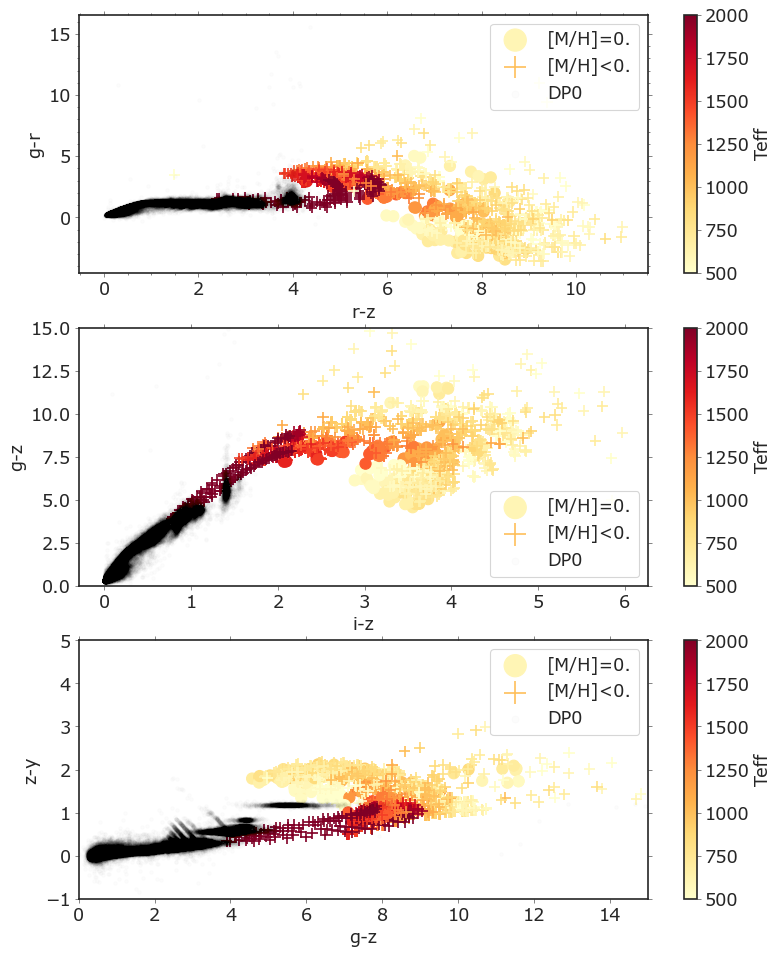

In [15]:
fig, (ax, ax1, ax2)=plt.subplots(figsize=(10, 12), nrows=3)
c=ax.scatter(df_line0.LSST_R-df_line0.LSST_Z, df_line0.LSST_G-df_line0.LSST_R, c=df_line0.teff.values, vmin=500, vmax=2000, marker='o', cmap='YlOrRd', label='[M/H]=0.', alpha=1, s=100)
ax.scatter(df_line1.LSST_R-df_line1.LSST_Z, df_line1.LSST_G-df_line1.LSST_R, c=df_line1.teff.values, vmin=500, vmax=2000, marker='+', cmap='YlOrRd', alpha=1, s=100)
ax.scatter(df_mov.LSST_R-df_mov.LSST_Z, df_mov.LSST_G-df_mov.LSST_R, c=df_mov.teff.values, vmin=500, vmax=2000, marker='+', cmap='YlOrRd', label='[M/H]<0.', alpha=1, s=100)
ax.scatter(dp0_data.mag_r-dp0_data.mag_z, dp0_data.mag_g-dp0_data.mag_r, color='k', label='DP0', s=10, alpha=0.01)

c=ax1.scatter(df_line0.LSST_I-df_line0.LSST_Z, df_line0.LSST_G-df_line0.LSST_Z, c=df_line0.teff.values, vmin=500, vmax=2000, marker='o', cmap='YlOrRd', label='[M/H]=0.', alpha=1, s=100)
ax1.scatter(df_line1.LSST_I-df_line1.LSST_Z, df_line1.LSST_G-df_line1.LSST_Z, c=df_line1.teff.values, vmin=500, vmax=2000, marker='+', cmap='YlOrRd', alpha=1, s=100)
ax1.scatter(df_mov.LSST_I-df_mov.LSST_Z, df_mov.LSST_G-df_mov.LSST_Z, c=df_mov.teff.values, vmin=500, vmax=2000, marker='+', cmap='YlOrRd', label='[M/H]<0.', alpha=1, s=100)
ax1.scatter(dp0_data.mag_i-dp0_data.mag_z, dp0_data.mag_g-dp0_data.mag_z, color='k', label='DP0', s=10, alpha=0.01)

c=ax2.scatter(df_line0.LSST_G-df_line0.LSST_Z, df_line0.LSST_Z-df_line0.LSST_Y, c=df_line0.teff.values, vmin=500, vmax=2000, marker='o', cmap='YlOrRd', label='[M/H]=0.', alpha=1, s=100)
ax2.scatter(df_line1.LSST_G-df_line1.LSST_Z, df_line1.LSST_Z-df_line1.LSST_Y, c=df_line1.teff.values, vmin=500, vmax=2000, marker='+', cmap='YlOrRd', alpha=1, s=100)
ax2.scatter(df_mov.LSST_G-df_mov.LSST_Z, df_mov.LSST_Z-df_mov.LSST_Y, c=df_mov.teff.values, vmin=500, vmax=2000, marker='+', cmap='YlOrRd', label='[M/H]<0.', alpha=1, s=100)
ax2.scatter(dp0_data.mag_g-dp0_data.mag_z, dp0_data.mag_z-dp0_data.mag_y, color='k', label='DP0', s=10, alpha=0.01)


for a in (ax, ax1, ax2):
    cbar=plt.colorbar(c, ax=a, label=r'Teff')
    ax.minorticks_on()
    a.legend(markerscale=2)
    plt.tight_layout()
    
    ax.minorticks_on()
    
ax.set(xlabel='r-z', ylabel='g-r')
ax1.set(xlabel='i-z', ylabel='g-z', ylim=[0, 15])
ax2.set(xlabel='g-z', ylabel='z-y', ylim=[-1, 5], xlim=[0, 15])
plt.savefig('../figures/lsst_color_selection.jpeg')